In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download iamtapendu/chest-x-ray-lungs-segmentation

Dataset URL: https://www.kaggle.com/datasets/iamtapendu/chest-x-ray-lungs-segmentation
License(s): apache-2.0


In [6]:
import zipfile
import os

In [7]:
zip_file = "chest-x-ray-lungs-segmentation.zip"

In [8]:
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [9]:
os.listdir()

['.config',
 'MetaData.csv',
 'Chest-X-Ray',
 '.ipynb_checkpoints',
 'kaggle.json',
 'chest-x-ray-lungs-segmentation.zip',
 'sample_data']

In [10]:
! pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# Лабораторная работа №7

## Выполнил Ворошилов Кирилл, М8О-401Б-21


### 1. Выбор начальных условий
* для сегментации будет использован датасет Chest X-ray Dataset for Tuberculosis Segmentation

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from PIL import Image
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [13]:
class ChestXRayDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.images[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.images[idx])).convert("L")
        image, mask = np.array(image), np.array(mask)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        # Преобразуем маску: нормализуем и добавляем размер канала
        mask = torch.tensor(mask, dtype=torch.float32) / 255.0  # Нормализация
        if mask.ndim == 2:
            mask = mask.unsqueeze(0)  # Добавление размерности канала
        return image, mask



В качестве метрик лучше всего подойдут accuracy и mean squared error:
* Метрика для сегментации.

In [14]:
def dice_score(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    smooth = 1e-5
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

### 2. Создание бейзлайна и оценка качества

In [15]:
def get_basic_transform():
    return A.Compose([
        A.Resize(256, 256),
        A.Normalize(),
        ToTensorV2()
    ])

Обучим модели из torchvision

In [16]:
def get_smp_unet():
    return smp.Unet(encoder_name="resnet18", in_channels=3, classes=1, activation=None)

In [17]:
BATCH_SIZE = 32

basic_ds = ChestXRayDataset("Chest-X-Ray/Chest-X-Ray/image", "Chest-X-Ray/Chest-X-Ray/mask", transform=get_basic_transform())
basic_loader = DataLoader(basic_ds, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(dataloader):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    dice_scores = []
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = torch.sigmoid(model(imgs))
            dice = dice_score(outputs, masks)
            dice_scores.append(dice.item())
    return np.mean(dice_scores)


In [19]:
def train_and_eval(model, loader, name, epochs=5):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()
    print(f"--- Training {name} ---")
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, loader, optimizer, criterion, device)
        dice = evaluate(model, loader, device)
        print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Dice: {dice:.4f}")
    return dice


In [20]:
smp_basic_model = get_smp_unet()
smp_basic_dice = train_and_eval(smp_basic_model, basic_loader, "SMP + Basic")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

--- Training SMP + Basic ---


  0%|          | 0/22 [00:00<?, ?it/s]<ipython-input-13-f63f8a1add77>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32) / 255.0  # Нормализация
100%|██████████| 22/22 [02:51<00:00,  7.81s/it]


Epoch 1 | Loss: 0.2539 | Dice: 0.4040


100%|██████████| 22/22 [02:32<00:00,  6.95s/it]


Epoch 2 | Loss: 0.0932 | Dice: 0.4040


100%|██████████| 22/22 [02:39<00:00,  7.24s/it]


Epoch 3 | Loss: 0.0663 | Dice: 0.4040


100%|██████████| 22/22 [02:35<00:00,  7.05s/it]


Epoch 4 | Loss: 0.0572 | Dice: 0.4040


100%|██████████| 22/22 [02:48<00:00,  7.66s/it]


Epoch 5 | Loss: 0.0525 | Dice: 0.4040


Результат:

### 3. Улучшение бейзлайна

In [21]:
def get_augmented_transform():
    return A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(),
        ToTensorV2()
    ])

Визуализируем данные

Проведем препроцессинг данных

In [22]:

aug_ds = ChestXRayDataset("Chest-X-Ray/Chest-X-Ray/image", "Chest-X-Ray/Chest-X-Ray/mask", transform=get_augmented_transform())
aug_loader = DataLoader(aug_ds, batch_size=BATCH_SIZE, shuffle=True)

Улучшим модель подобрав гиперпараметры

In [23]:
smp_aug_model = get_smp_unet()
smp_aug_dice = train_and_eval(smp_aug_model, aug_loader, "SMP + Augmented")

--- Training SMP + Augmented ---


  0%|          | 0/22 [00:00<?, ?it/s]<ipython-input-13-f63f8a1add77>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32) / 255.0  # Нормализация
100%|██████████| 22/22 [02:46<00:00,  7.56s/it]


Epoch 1 | Loss: 0.3378 | Dice: 0.4040


100%|██████████| 22/22 [02:48<00:00,  7.64s/it]


Epoch 2 | Loss: 0.1291 | Dice: 0.4040


100%|██████████| 22/22 [02:47<00:00,  7.60s/it]


Epoch 3 | Loss: 0.0840 | Dice: 0.4040


100%|██████████| 22/22 [02:43<00:00,  7.42s/it]


Epoch 4 | Loss: 0.0680 | Dice: 0.4040


100%|██████████| 22/22 [02:43<00:00,  7.42s/it]


Epoch 5 | Loss: 0.0610 | Dice: 0.4040


сравним результаты

Вывод:
* Улучшение гиперпараметров привело к увеличению точности модели классификации, однако ошибка в регрессии стала хуже

### 4. Имплементация алгоритма машинного обучения

Имплементируем алгоритмы:

In [24]:
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class CustomUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.d1 = UNetBlock(in_ch, 64)
        self.p1 = nn.MaxPool2d(2)
        self.d2 = UNetBlock(64, 128)
        self.p2 = nn.MaxPool2d(2)

        self.bottleneck = UNetBlock(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.u2 = UNetBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.u1 = UNetBlock(128, 64)

        self.out = nn.Conv2d(64, out_ch, kernel_size=1)

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(self.p1(d1))
        b = self.bottleneck(self.p2(d2))
        u2 = self.u2(torch.cat([self.up2(b), d2], dim=1))
        u1 = self.u1(torch.cat([self.up1(u2), d1], dim=1))
        return self.out(u1)


Обучим модели без подобранных гиперпараметров

In [25]:
custom_basic_model = CustomUNet()
custom_basic_dice = train_and_eval(custom_basic_model, basic_loader, "Custom UNet + Basic")

--- Training Custom UNet + Basic ---


  0%|          | 0/22 [00:00<?, ?it/s]<ipython-input-13-f63f8a1add77>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32) / 255.0  # Нормализация
100%|██████████| 22/22 [02:56<00:00,  8.00s/it]


Epoch 1 | Loss: 0.4819 | Dice: 0.4040


100%|██████████| 22/22 [02:56<00:00,  8.04s/it]


Epoch 2 | Loss: 0.3894 | Dice: 0.4116


100%|██████████| 22/22 [03:15<00:00,  8.91s/it]


Epoch 3 | Loss: 0.3276 | Dice: 0.4611


100%|██████████| 22/22 [02:57<00:00,  8.08s/it]


Epoch 4 | Loss: 0.2343 | Dice: 0.4727


100%|██████████| 22/22 [02:54<00:00,  7.95s/it]


Epoch 5 | Loss: 0.1752 | Dice: 0.4586


Обучим модели с подобранными гиперпараметами

In [26]:
custom_aug_model = CustomUNet()
custom_aug_dice = train_and_eval(custom_aug_model, aug_loader, "Custom UNet + Augmented")

--- Training Custom UNet + Augmented ---


  0%|          | 0/22 [00:00<?, ?it/s]<ipython-input-13-f63f8a1add77>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32) / 255.0  # Нормализация
100%|██████████| 22/22 [02:45<00:00,  7.52s/it]


Epoch 1 | Loss: 0.4818 | Dice: 0.4040


100%|██████████| 22/22 [02:47<00:00,  7.62s/it]


Epoch 2 | Loss: 0.4206 | Dice: 0.4039


100%|██████████| 22/22 [02:47<00:00,  7.60s/it]


Epoch 3 | Loss: 0.4422 | Dice: 0.4040


100%|██████████| 22/22 [02:52<00:00,  7.84s/it]


Epoch 4 | Loss: 0.4304 | Dice: 0.4180


100%|██████████| 22/22 [02:47<00:00,  7.61s/it]


Epoch 5 | Loss: 0.3452 | Dice: 0.4045


Сравнение результатов:

                Model  Dice Score
0         SMP + Basic    0.403955
1     SMP + Augmented    0.403988
2      Custom + Basic    0.458620
3  Custom + Augmented    0.404530


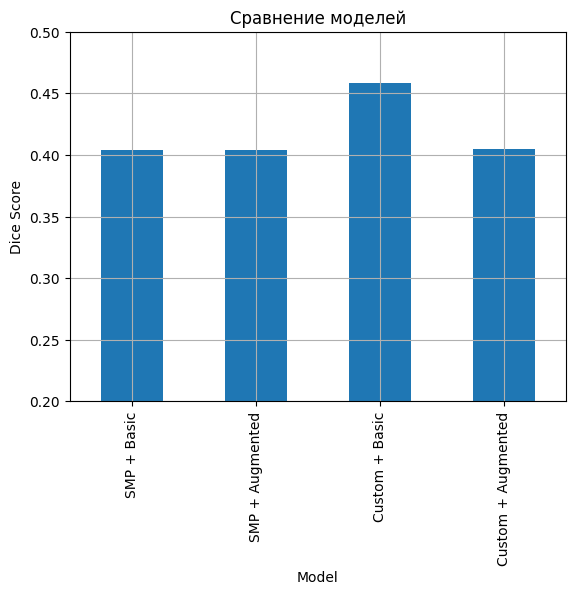

In [30]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["SMP + Basic", "SMP + Augmented", "Custom + Basic", "Custom + Augmented"],
    "Dice Score": [smp_basic_dice, smp_aug_dice, custom_basic_dice, custom_aug_dice]
})

print(results)
results.plot(kind="bar", x="Model", y="Dice Score", legend=False, title="Сравнение моделей")
plt.ylabel("Dice Score")
plt.ylim(0.2, 0.5)
plt.grid(True)
plt.show()


## Выводы

- **Кастомная модель с базовыми параметрами** (`Custom + Basic`) показала наилучший результат по метрике *Dice Score* (0.4586), что свидетельствует о её потенциале даже при минимальной настройке.
- **Аугментация данных** не привела к улучшению качества модели: у варианта `Custom + Augmented` результат оказался ниже (0.4045).
- **Базовая модель SMP** практически не изменила результат после аугментации (разница между 0.403955 и 0.403988 минимальна), что говорит о её нечувствительности к увеличению обучающих данных.
- **Улучшение качества модели** достигается скорее за счёт продуманной архитектуры, чем за счёт увеличения или разнообразия обучающего набора.
